In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.5 MB/s eta 0:00:00


In [2]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import lightgbm as lgb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/디스커버/25-1/가이드프로젝트/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/디스커버/25-1/가이드프로젝트/test.csv')

In [6]:
train_data.isnull().sum()

,0
ID,0
매물확인방식,0
보증금,0
월세,0
전용면적,787
해당층,229
총층,16
방향,0
방수,16
욕실수,18


1. 결측치
- 해당층, 전용면적, 총주차대수 총층 -> knn imputer(나머지는 큰 분포차이 x but 전용면적은 분포 차이를 보임,, 평균으로 대체한 것 보다는 나음.)
- 욕실수, 방수 -> 범주형 변수이므로 최빈값으로 대체 (큰 분포 차이 x)

In [7]:
# Null값 개수 컬럼 추가
train_data['na_cnt'] = train_data.isnull().sum(1)

📊 '해당층' 단일 변수에 대한 시각화 진행...
🔍 '해당층' 연속형 여부: True
📈 '해당층'은 연속형 변수로 처리됩니다.


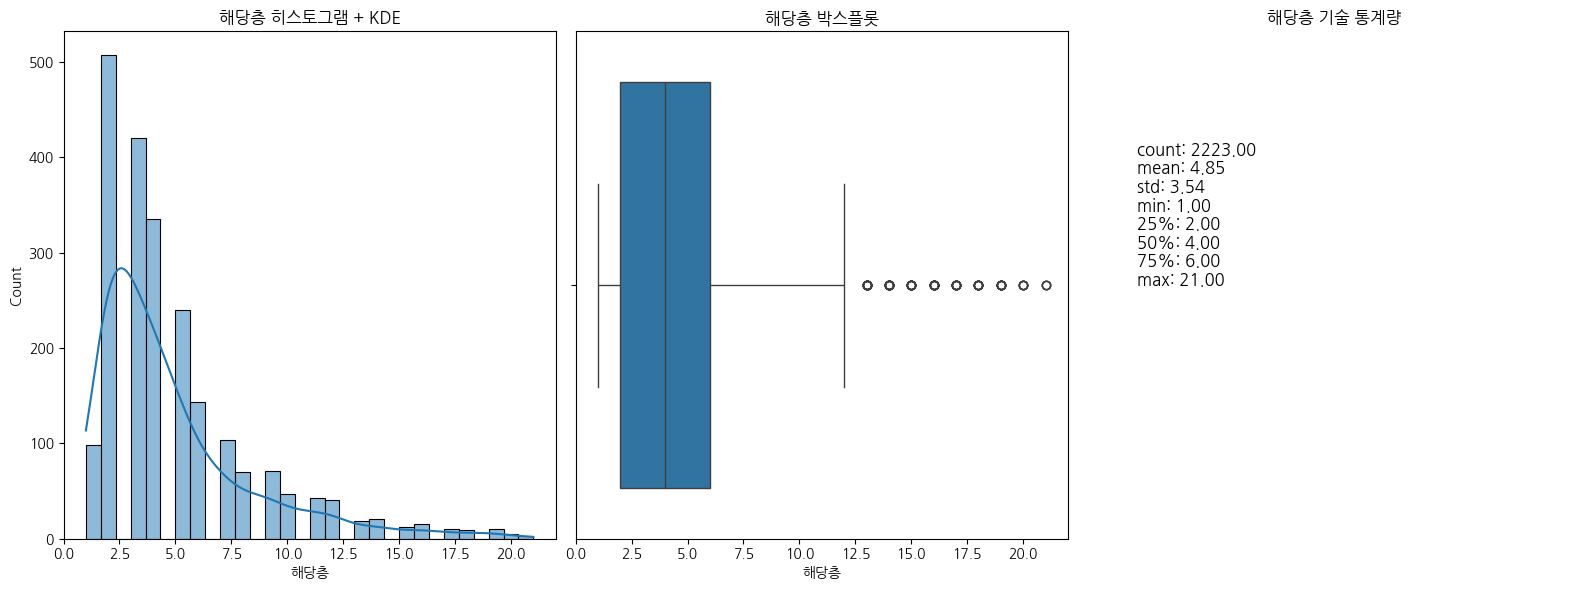

📊 '전용면적' 단일 변수에 대한 시각화 진행...
🔍 '전용면적' 연속형 여부: True
📈 '전용면적'은 연속형 변수로 처리됩니다.


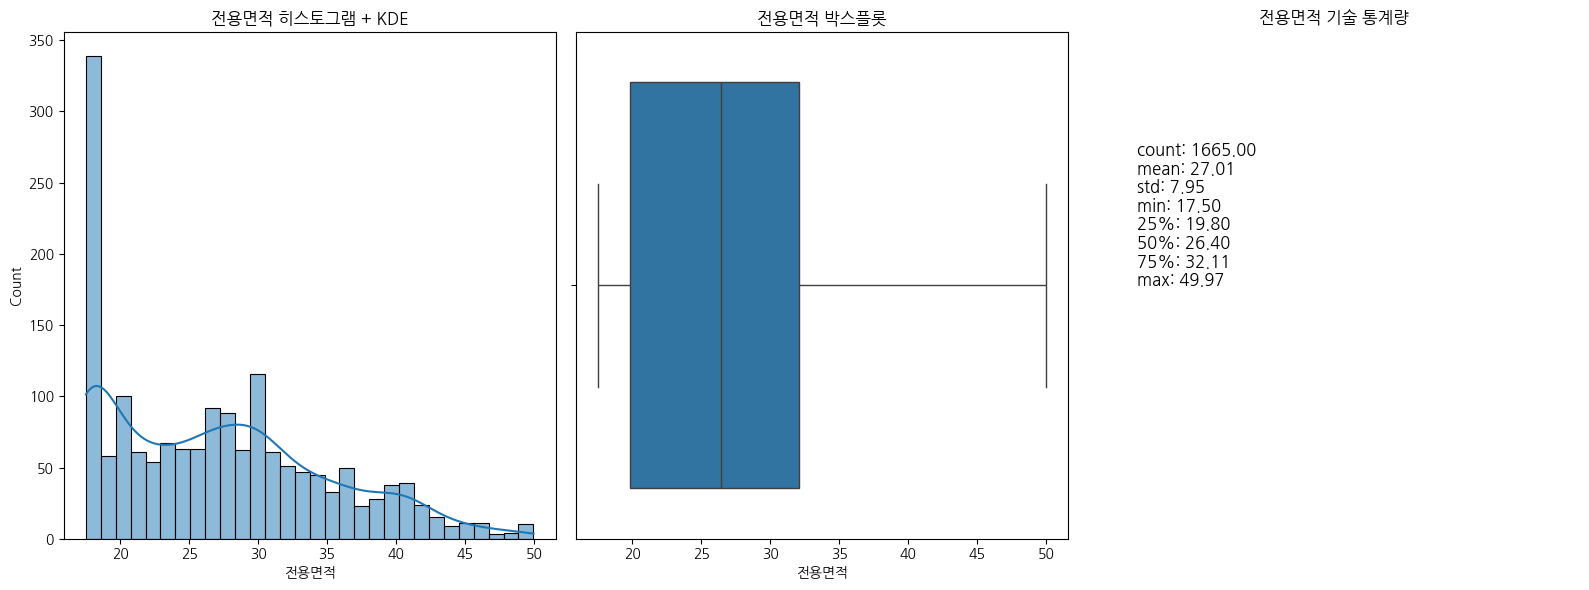

📊 '총주차대수' 단일 변수에 대한 시각화 진행...
🔍 '총주차대수' 연속형 여부: True
📈 '총주차대수'은 연속형 변수로 처리됩니다.


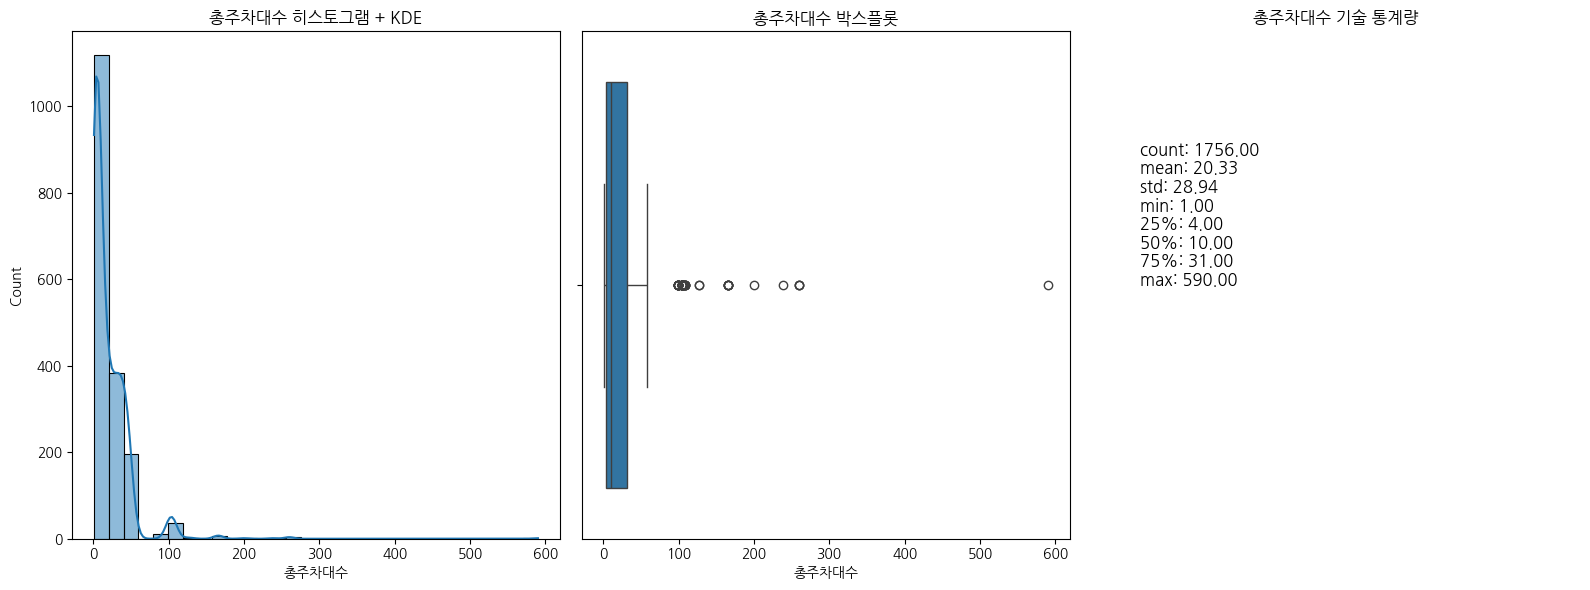

📊 '총층' 단일 변수에 대한 시각화 진행...
🔍 '총층' 연속형 여부: True
📈 '총층'은 연속형 변수로 처리됩니다.


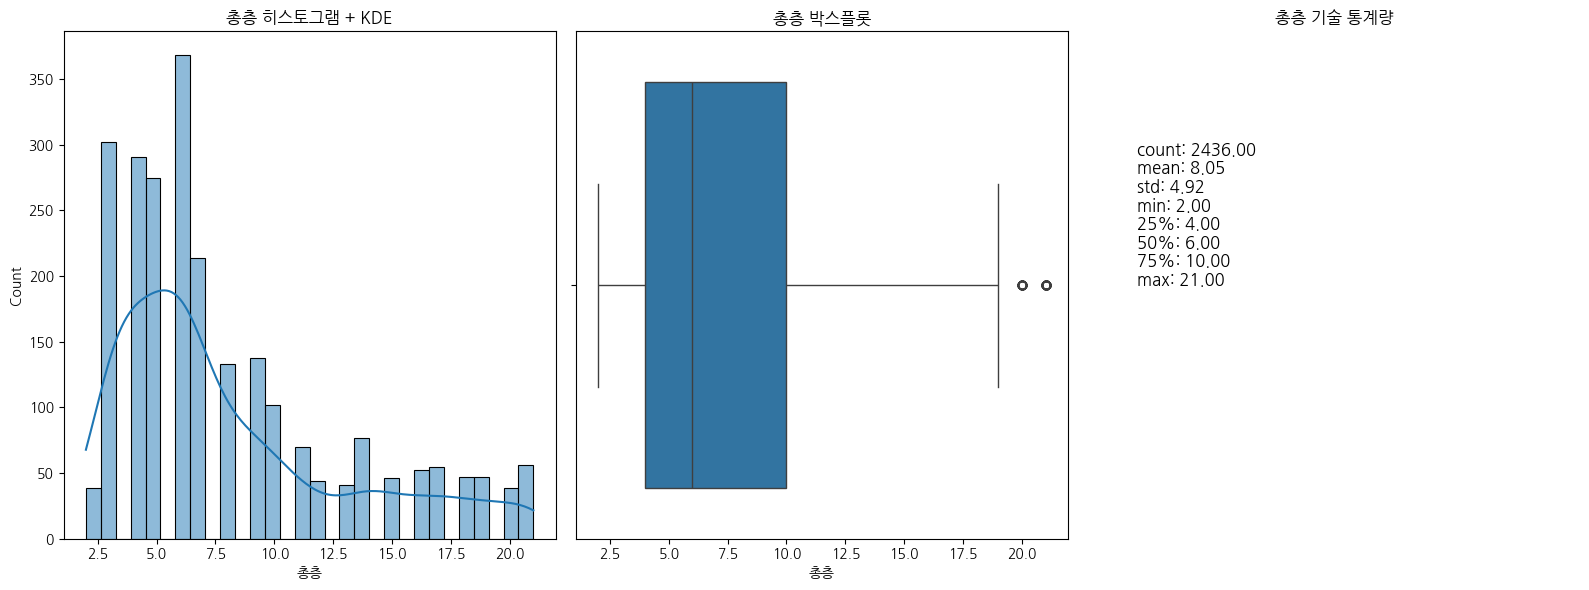

📊 '방수' 단일 변수에 대한 시각화 진행...
🔍 '방수' 연속형 여부: False
📊 '방수'은 범주형 변수로 처리됩니다.


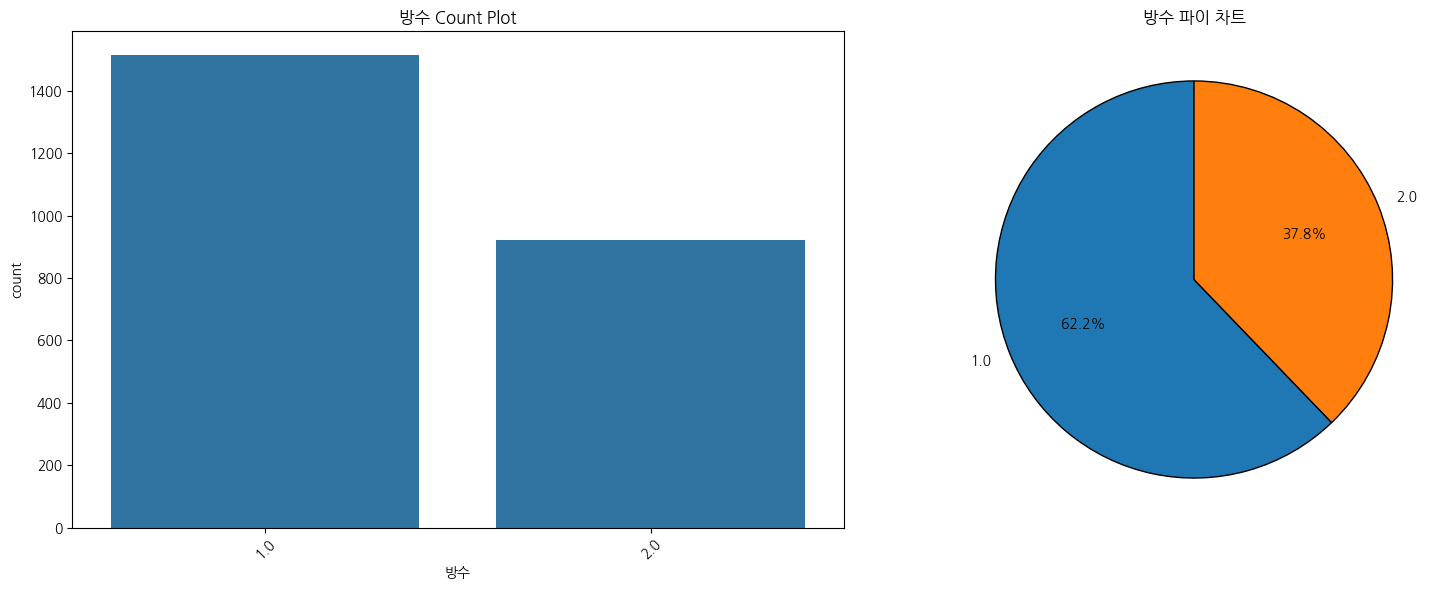

📊 '욕실수' 단일 변수에 대한 시각화 진행...
🔍 '욕실수' 연속형 여부: False
📊 '욕실수'은 범주형 변수로 처리됩니다.


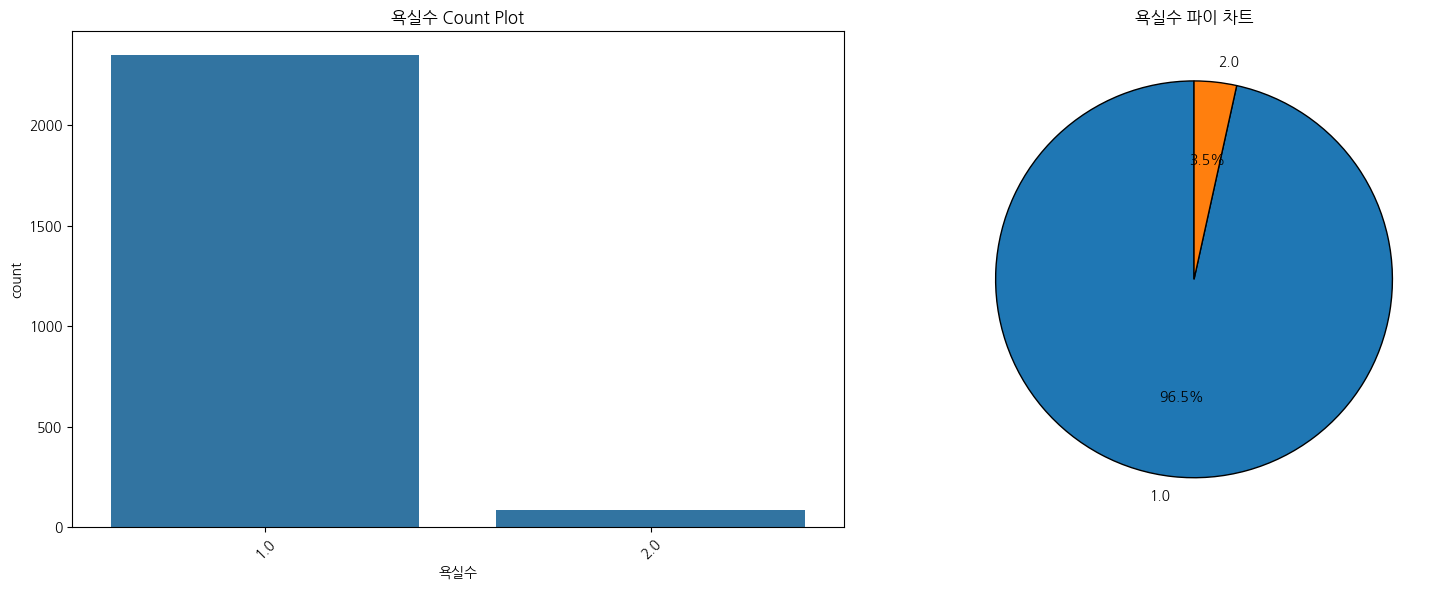

In [ ]:
# # 결측치 처리 전 그래프
# auto_visualize(train_data, '해당층')
# auto_visualize(train_data, '전용면적')
# auto_visualize(train_data, '총주차대수')
# auto_visualize(train_data, '총층')
# auto_visualize(train_data, '방수')
# auto_visualize(train_data, '욕실수')

In [8]:
train_data.describe()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물여부,na_cnt
count,2.452000e+03,2452.000000,1665.000000,2223.000000,2436.000000,2436.000000,2434.000000,1756.000000,2452.000000,2452.000000,2452.000000
mean,1.574188e+08,380420.065253,27.009628,4.848403,8.052545,1.378079,1.034511,20.332574,5.477977,0.121533,0.718597
std,1.212794e+08,206425.413601,7.951757,3.543348,4.920112,0.485007,0.182575,28.939900,5.631185,0.326813,0.903286
min,5.000000e+06,0.000000,17.500000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,7.500000e+07,200000.000000,19.800000,2.000000,4.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000
50%,1.325000e+08,380000.000000,26.400000,4.000000,6.000000,1.000000,1.000000,10.000000,5.000000,0.000000,0.000000
75%,1.890000e+08,550000.000000,32.110000,6.000000,10.000000,2.000000,1.000000,31.000000,9.000000,0.000000,1.000000
max,4.090000e+08,750000.000000,49.970000,21.000000,21.000000,2.000000,2.000000,590.000000,96.000000,1.000000,6.000000


In [9]:
# 결측치 처리
from sklearn.impute import KNNImputer
columns_fill_knn = ['전용면적', '해당층', '총주차대수', '총층']
imputer = KNNImputer(n_neighbors=5)
train_data[columns_fill_knn] = imputer.fit_transform(train_data[columns_fill_knn])

# 범주형 변수의 경우 KNN IMPUTER 사용이 어려워 최빈값으로 대체(결측치 수 적음)
for col in ['방수', '욕실수']:
    mode_val = train_data[col].mode()[0]
    train_data[col].fillna(mode_val, inplace=True)

<ipython-input-9-d9af3ce00e40>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mode_val, inplace=True)


📊 '해당층' 단일 변수에 대한 시각화 진행...
🔍 '해당층' 연속형 여부: True
📈 '해당층'은 연속형 변수로 처리됩니다.


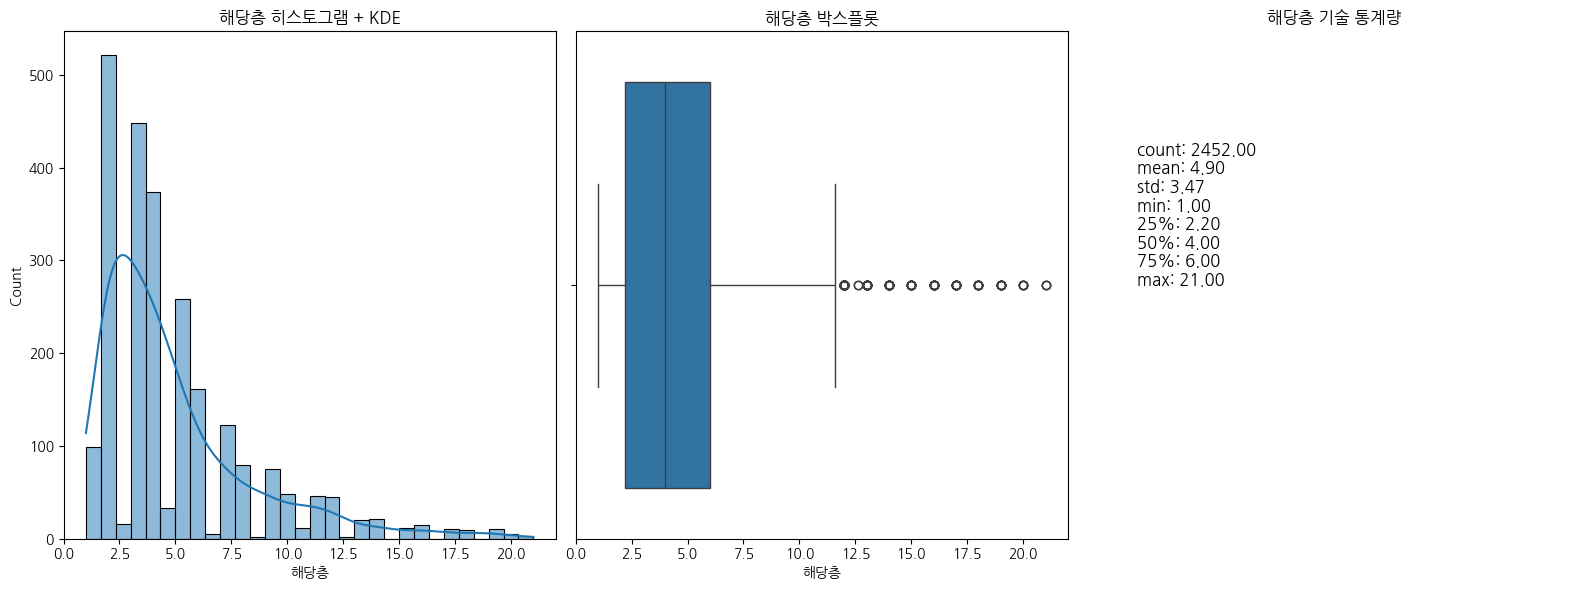

📊 '전용면적' 단일 변수에 대한 시각화 진행...
🔍 '전용면적' 연속형 여부: True
📈 '전용면적'은 연속형 변수로 처리됩니다.


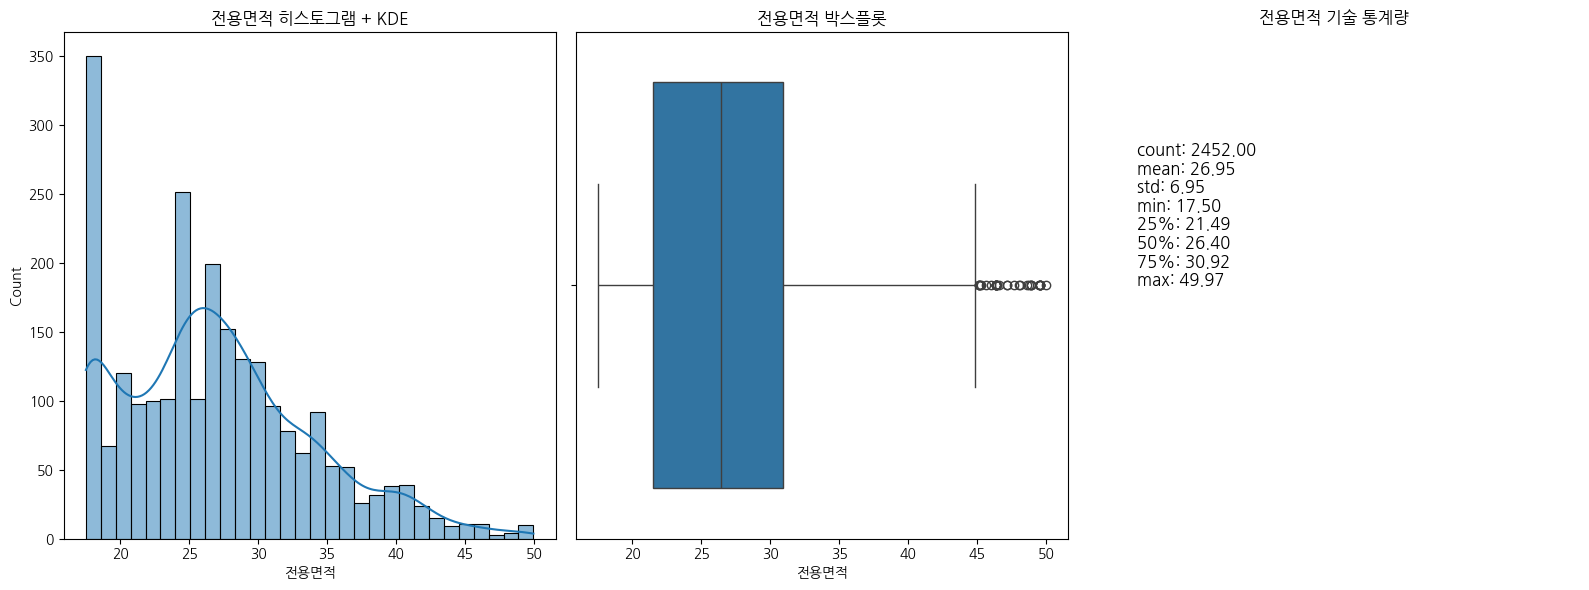

📊 '총주차대수' 단일 변수에 대한 시각화 진행...
🔍 '총주차대수' 연속형 여부: True
📈 '총주차대수'은 연속형 변수로 처리됩니다.


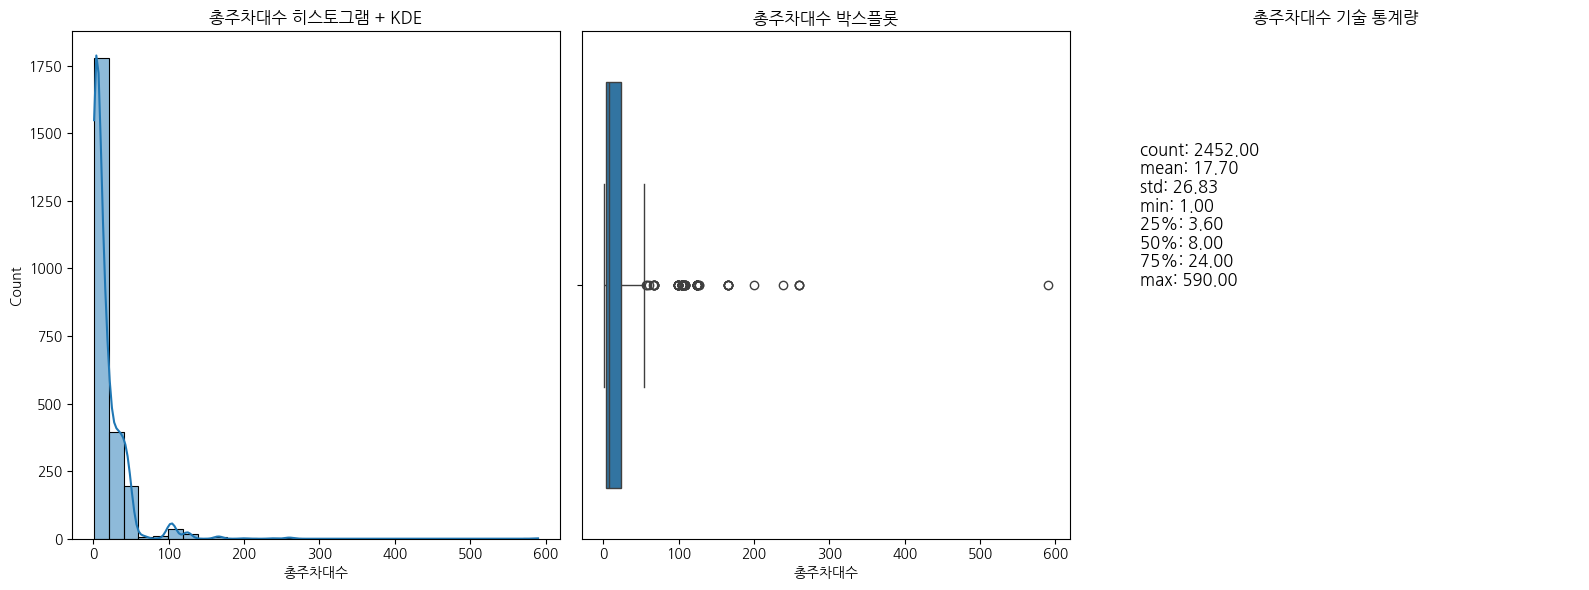

📊 '총층' 단일 변수에 대한 시각화 진행...
🔍 '총층' 연속형 여부: True
📈 '총층'은 연속형 변수로 처리됩니다.


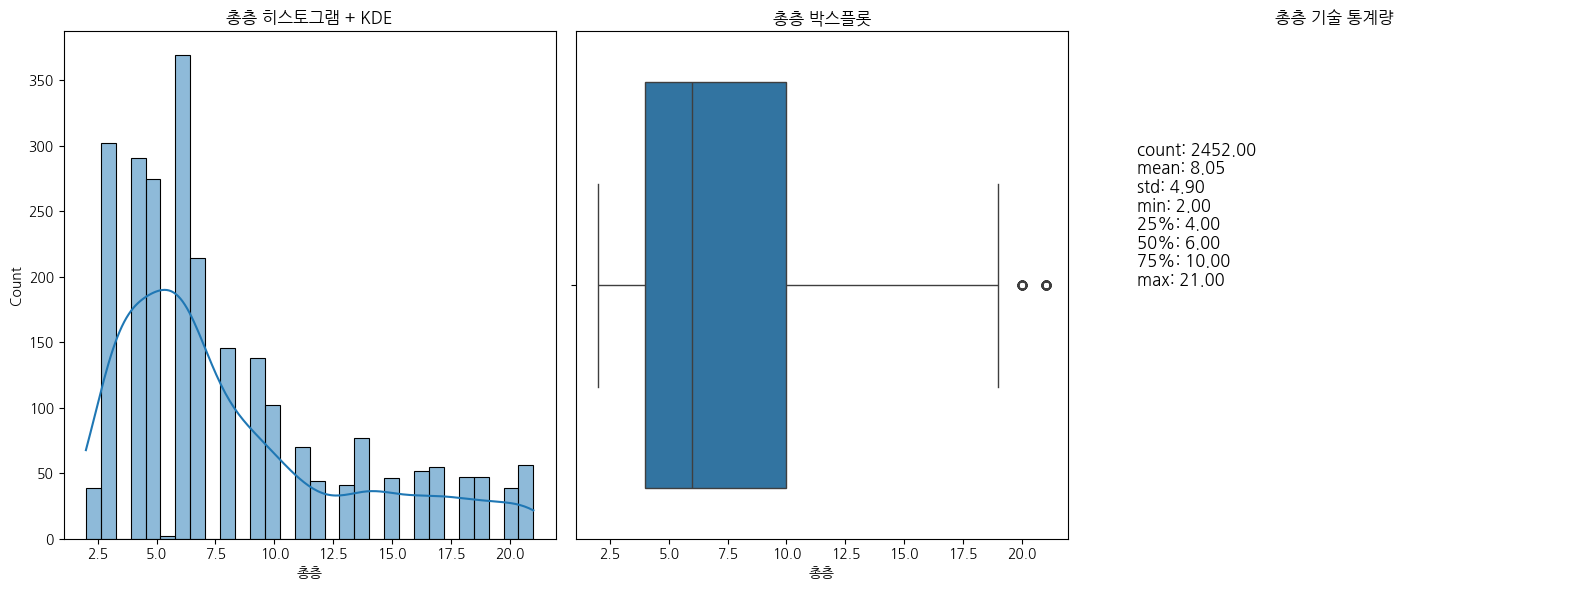

📊 '방수' 단일 변수에 대한 시각화 진행...
🔍 '방수' 연속형 여부: False
📊 '방수'은 범주형 변수로 처리됩니다.


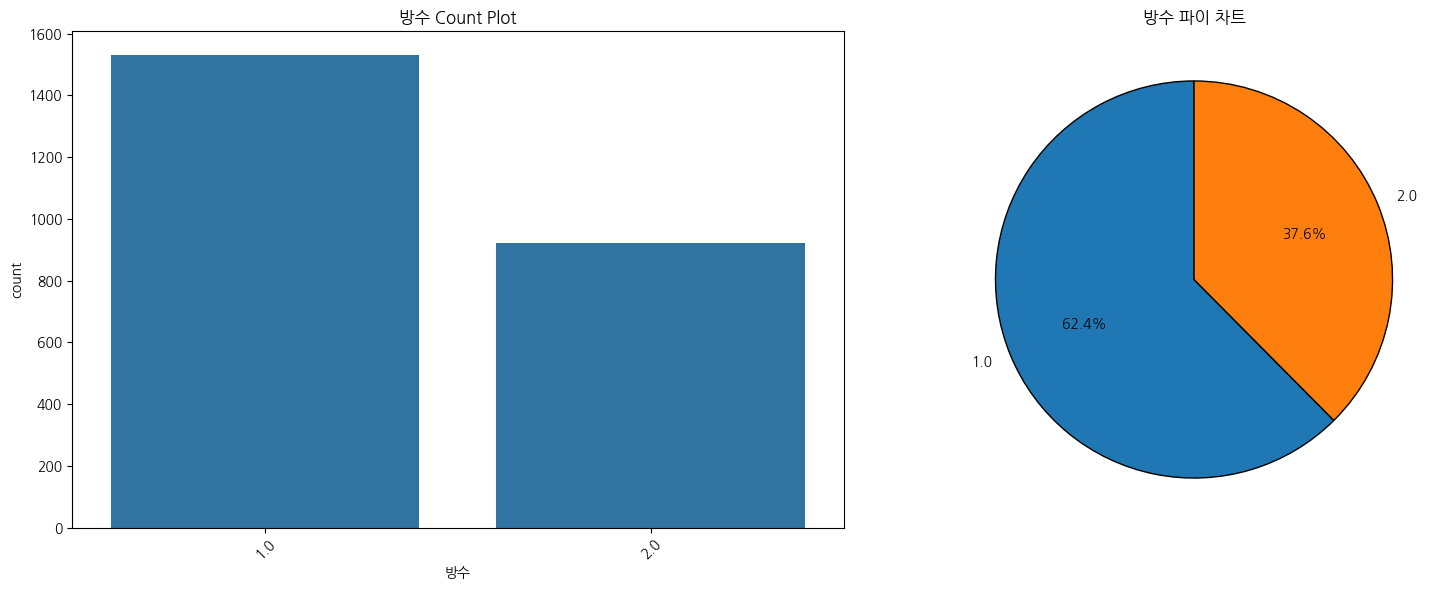

📊 '욕실수' 단일 변수에 대한 시각화 진행...
🔍 '욕실수' 연속형 여부: False
📊 '욕실수'은 범주형 변수로 처리됩니다.


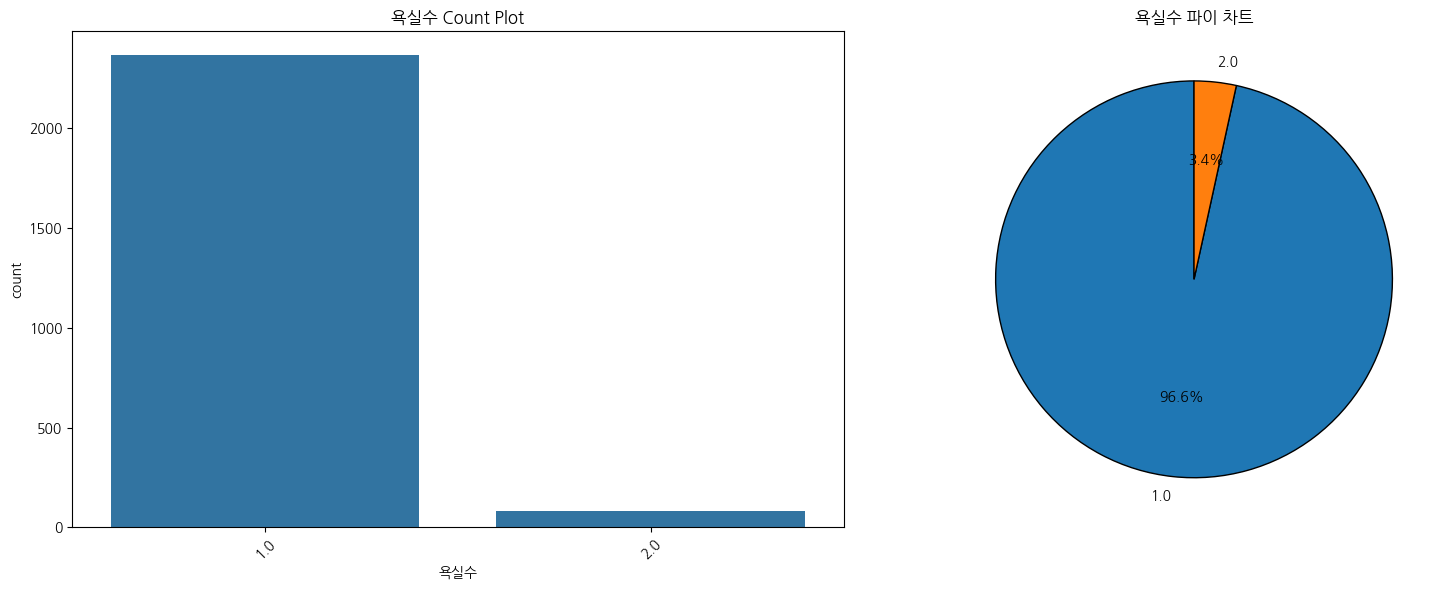

In [ ]:
# # 결측치 처리 후 그래프
# auto_visualize(train_data, '해당층')
# auto_visualize(train_data, '전용면적')
# auto_visualize(train_data, '총주차대수')
# auto_visualize(train_data, '총층')
# auto_visualize(train_data, '방수')
# auto_visualize(train_data, '욕실수')

2. 계절 컬럼 추가
- 중간과 동일

In [10]:
# 날짜를 datetime 형식으로 변환
train_data['게재일'] = pd.to_datetime(train_data['게재일'], errors='coerce')
# 월 컬럼 생성
train_data['월'] = train_data['게재일'].dt.month
# 계절 컬럼 생성
def get_season(month):
  계절 = {
  12: '겨울', 1: '겨울', 2: '겨울',
  3: '봄', 4: '봄', 5: '봄',
  6: '여름', 7: '여름', 8: '여름',
  9: '가을', 10: '가을', 11: '가을'
  }
  return 계절.get(month, '가을')

train_data['계절'] = train_data['월'].apply(get_season)

# 계절 순서 지정
계절_순서 = ['봄', '여름', '가을', '겨울']
train_data['계절'] = pd.Categorical(train_data['계절'], categories=계절_순서, ordered=True)

# 사이클릭 변환
train_data['월_sin'] = np.sin(2 * np.pi * train_data['월'] / 12)
train_data['월_cos'] = np.cos(2 * np.pi * train_data['월'] / 12)

# 불필요한 컬럼 제거
train_data.drop(['게재일', '월'], axis=1, inplace=True)

3. 이상치
- 전용면적, 총주차대수 log화

📊 '전용면적' 단일 변수에 대한 시각화 진행...
🔍 '전용면적' 연속형 여부: True
📈 '전용면적'은 연속형 변수로 처리됩니다.


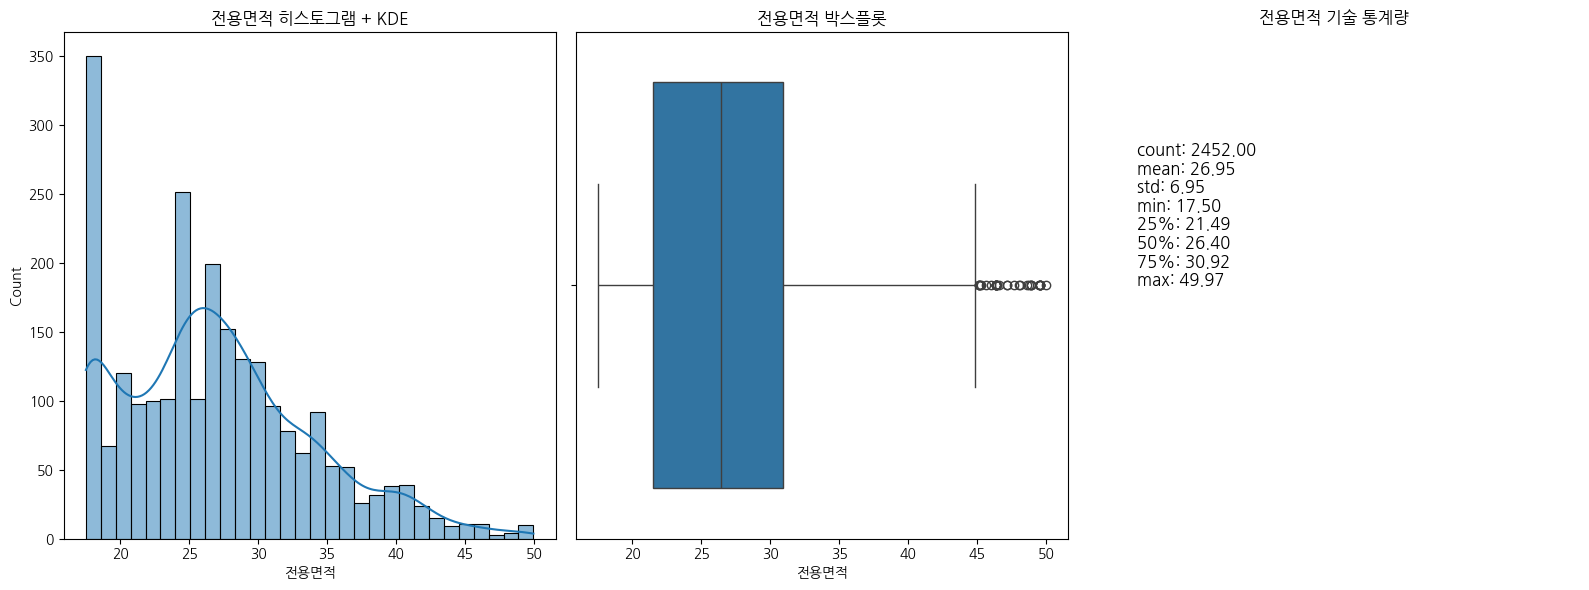

📊 '총주차대수' 단일 변수에 대한 시각화 진행...
🔍 '총주차대수' 연속형 여부: True
📈 '총주차대수'은 연속형 변수로 처리됩니다.


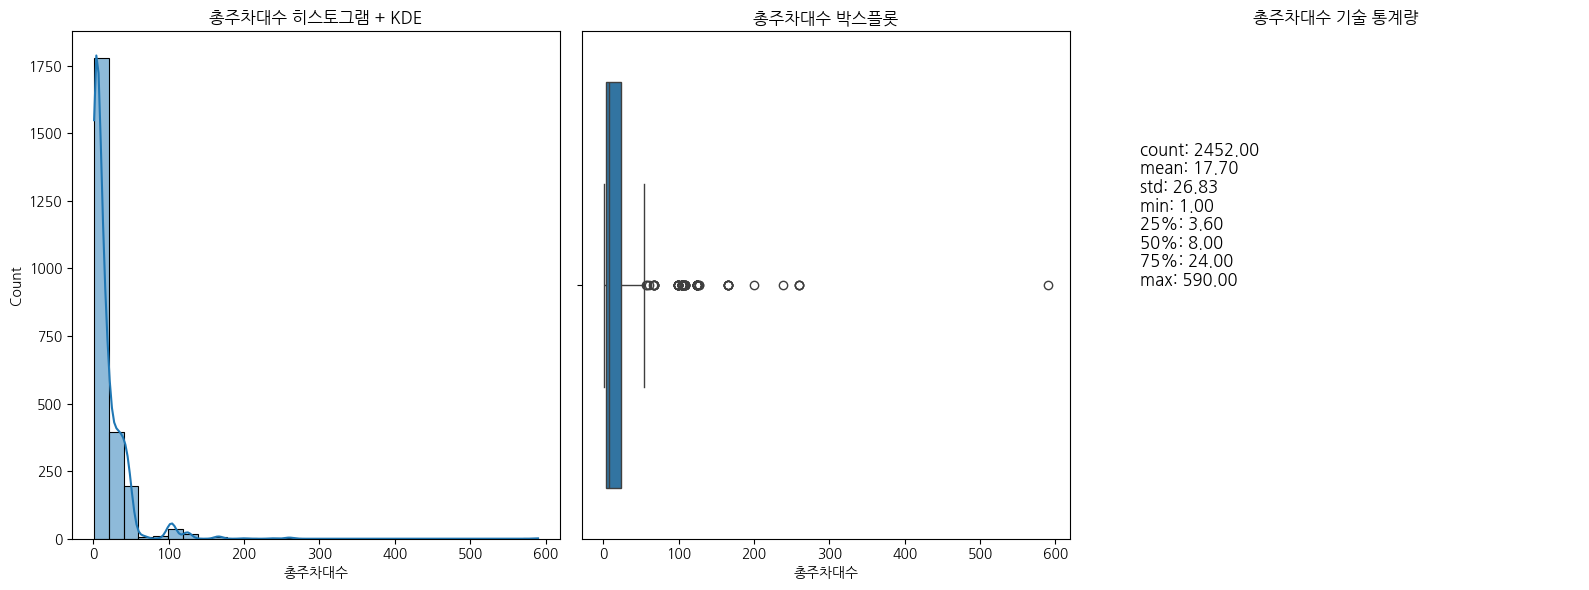

📊 '보증금' 단일 변수에 대한 시각화 진행...
🔍 '보증금' 연속형 여부: True
📈 '보증금'은 연속형 변수로 처리됩니다.


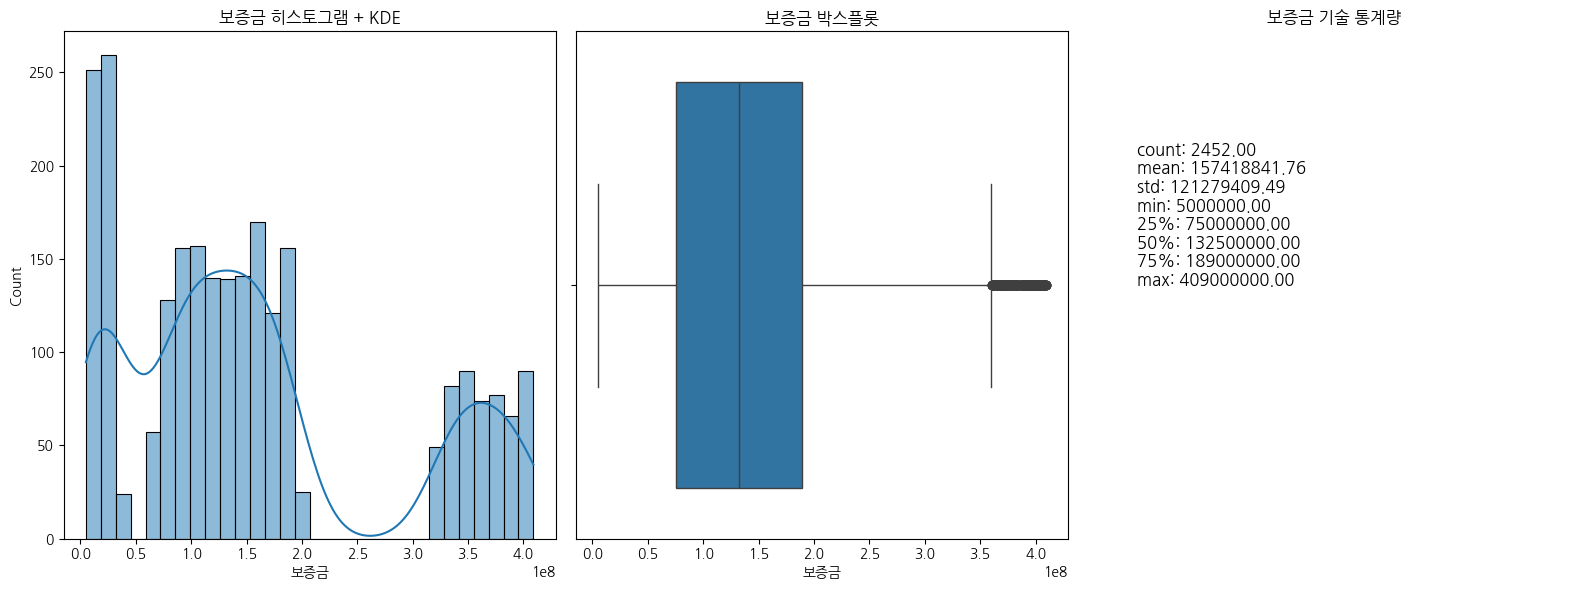

In [ ]:
# auto_visualize(train_data, '전용면적')
# auto_visualize(train_data, '총주차대수')
# auto_visualize(train_data, '보증금')

In [11]:
import numpy as np
import pandas as pd

def log_transform_columns(df, columns, drop_original=False):

    df_copy = df.copy()

    for col in columns:
        if (df_copy[col] <= 0).any():
            print(f"⚠️ Warning: 컬럼 '{col}' 에 0 이하 값이 있어 로그화 생략!")
            continue
        new_col_name = col + '_log' if not drop_original else col
        df_copy[new_col_name] = np.log1p(df_copy[col])
        print(f"✅ 컬럼 '{col}' → '{new_col_name}' 로 로그 변환 완료!")

        if drop_original:
            df_copy.drop(columns=[col], inplace=True)

    return df_copy


selected_cols = ['전용면적', '총주차대수', '보증금']
train_data = log_transform_columns(train_data, selected_cols, drop_original=True)


✅ 컬럼 '전용면적' → '전용면적' 로 로그 변환 완료!
✅ 컬럼 '총주차대수' → '총주차대수' 로 로그 변환 완료!
✅ 컬럼 '보증금' → '보증금' 로 로그 변환 완료!


4. 결측치 개수 컬럼
- 결측치 개수에 따른 컬럼 추가 (코드는 결측치 처리 부분에 있음)

5. 주차관련
- 주차가능여부 == 불가능 and 총주차대수 != 0 인 경우 구분하는 컬럼 추가
- 주차구라 column (0 or 1 값 가짐) -> 위의 방법으로 처리하니 성능 하락 -> 빼고 진행

In [ ]:
# train_data['주차구라'] = 0
# train_data[(train_data['주차가능여부'] == '불가능') & (train_data['총주차대수'] != 0)]['주차구라'] = 1

6. 인코딩
- 'ID' 컬럼 drop
- '매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '계절' -> 라벨 인코딩

In [12]:
train_data.drop(columns = 'ID', inplace = True)

In [13]:
from sklearn.preprocessing import LabelEncoder

cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '계절']

for col in cols:
  le = LabelEncoder()
  train_data[col] = le.fit_transform(train_data[col])

7. 오버셈플링
- SMOTE 이용해 오버셈플링 -> threshold 조정 실패 -> 빼고 진행

In [ ]:
# from imblearn.over_sampling import SMOTE

# X = train_data.drop(columns = ['허위매물여부'])
# y = train_data['허위매물여부']

# # 컬럼 이름을 문자열로 변환
# X.columns = X.columns.astype(str)

# # SMOTE로 데이터 증강 -> data 불균형 문제 해결 위함
# smote = SMOTE(random_state=42)
# X_sm, y_sm = smote.fit_resample(X, y)

# # 확인
# print("After SMOTE, X_sm shape:", X_sm.shape)
# print("After SMOTE, y_sm distribution:\n", pd.Series(y_sm).value_counts())

After SMOTE, X_sm shape: (4308, 15)
After SMOTE, y_sm distribution:
 허위매물여부
0    2154
1    2154
Name: count, dtype: int64


In [14]:
# Null값 개수 컬럼 추가
test_data['na_cnt'] = test_data.isnull().sum(1)

# 결측치 처리
from sklearn.impute import KNNImputer
columns_fill_knn = ['전용면적', '해당층', '총주차대수', '총층']
imputer = KNNImputer(n_neighbors=5)
test_data[columns_fill_knn] = imputer.fit_transform(test_data[columns_fill_knn])

# 범주형 변수의 경우 KNN IMPUTER 사용이 어려워 최빈값으로 대체(결측치 수 적음)
for col in ['방수', '욕실수']:
    mode_val = test_data[col].mode()[0]
    test_data[col].fillna(mode_val, inplace=True)



# 날짜를 datetime 형식으로 변환
test_data['게재일'] = pd.to_datetime(test_data['게재일'], errors='coerce')
# 월 컬럼 생성
test_data['월'] = test_data['게재일'].dt.month
# 계절 컬럼 생성
def get_season(month):
  계절 = {
  12: '겨울', 1: '겨울', 2: '겨울',
  3: '봄', 4: '봄', 5: '봄',
  6: '여름', 7: '여름', 8: '여름',
  9: '가을', 10: '가을', 11: '가을'
  }
  return 계절.get(month, '가을')

test_data['계절'] = test_data['월'].apply(get_season)

# 계절 순서 지정
계절_순서 = ['봄', '여름', '가을', '겨울']
test_data['계절'] = pd.Categorical(test_data['계절'], categories=계절_순서, ordered=True)

# 사이클릭 변환
test_data['월_sin'] = np.sin(2 * np.pi * test_data['월'] / 12)
test_data['월_cos'] = np.cos(2 * np.pi * test_data['월'] / 12)

# 불필요한 컬럼 제거
test_data.drop(['게재일', '월'], axis=1, inplace=True)

# 로그 변환 적용!
selected_cols = ['전용면적', '총주차대수', '보증금']
test_data = log_transform_columns(test_data, selected_cols, drop_original=True)

# test_data['주차구라'] = 0
# test_data[(test_data['주차가능여부'] == '불가능') & (test_data['총주차대수'] != 0)]['주차구라'] = 1

test_data.drop(columns = 'ID', inplace = True)


from sklearn.preprocessing import LabelEncoder

cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '계절']

for col in cols:
  le = LabelEncoder()
  test_data[col] = le.fit_transform(test_data[col])

✅ 컬럼 '전용면적' → '전용면적' 로 로그 변환 완료!
✅ 컬럼 '총주차대수' → '총주차대수' 로 로그 변환 완료!
✅ 컬럼 '보증금' → '보증금' 로 로그 변환 완료!


<ipython-input-14-175db689bd6c>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[col].fillna(mode_val, inplace=True)


8. optuna
- optuna 설명(중간발표때 설명 못함)
- xgboost랑 smote간 관계, 이점 설명 가능

In [15]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = train_data.drop(columns = ['허위매물여부'])
y = train_data['허위매물여부']

def objective(trial):
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 5e-5, 1e-2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 5e-5, 1e-2, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 200, log=True),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10, step=2),
        'random_state': 42,
        'tree_method': 'hist',
        'verbosity': 0
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    return f1

# Optuna 스터디 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# 결과 출력
print("Best trial:")
print("  Value (F1 Score):", study.best_value)
print("  Params:", study.best_params)



[I 2025-04-09 06:11:42,830] A new study created in memory with name: no-name-3d75914b-937f-469c-867d-0b749c15f6f8
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [3, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 19].
  warnings.warn(
[I 2025-04-09 06:11:44,305] Trial 0 finished with value: 0.7194587383266628 and parameters: {'n_estimators': 500, 'learning_rate': 0.01777949402619769, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7472290195379943, 'colsample_bytree': 0.9053985293324376, 'gamma': 0.7889963112144793, 'reg_alpha': 0.00030952511841752215, 'reg_lambda': 0.006158491778546933, 'scale_pos_weight': 37.2673743249395, 'max_delta_step': 2}. Best is trial 0 with value: 0.7194587383266628.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [3, 20] and step=2, but the range is not divisible by `step`. It will b

Best trial:
  Value (F1 Score): 0.9015368149969063
  Params: {'n_estimators': 900, 'learning_rate': 0.08177590309814921, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.7031632591232179, 'colsample_bytree': 0.6428539003571438, 'gamma': 0.5100404269736124, 'reg_alpha': 0.0014346414535999327, 'reg_lambda': 0.0034779321166631743, 'scale_pos_weight': 4.639997632746052, 'max_delta_step': 6}


In [16]:
best_params = study.best_params
best_params['random_state'] = 42
best_params['tree_method'] = 'hist'
best_params['verbosity'] = 0

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6428539003571438, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5100404269736124,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08177590309814921,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=6, max_depth=15, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# test 데이터 처리

In [17]:
test_data.columns = test_data.columns.astype(str)
pred = pd.Series(final_model.predict(test_data))

In [18]:
submit = pd.read_csv('/content/drive/MyDrive/디스커버/25-1/가이드프로젝트/sample_submission.csv')

In [19]:
submit['허위매물여부'] = pred
submit.head()

,ID,허위매물여부
0,TEST_000,0
1,TEST_001,0
2,TEST_002,1
3,TEST_003,0
4,TEST_004,0


In [20]:
submit.to_csv('./submission(no_gura_yes_log2_1000times).csv',index=False)